Firstly, I'll show what the phase space diagram of a SHO not at rest looks like. I assume by not at rest, there is motion of the SHO along the axis of oscillation. In this case, the phase space diagram will look like the one below:

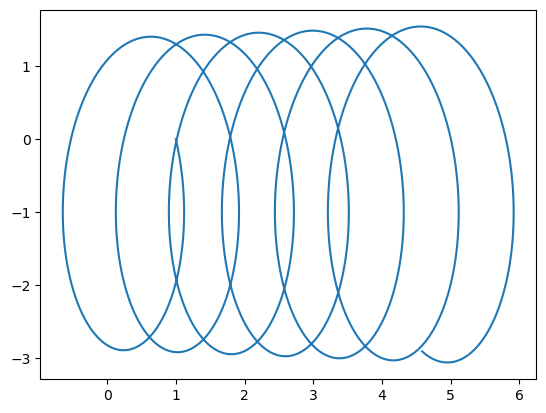

In [166]:
import numpy as np
import pylab as p

tmin = 0.0
tmax = 20.0
nts = 10000

x0 = 1
v0 = 1
w = 2
phi = 0

def SHO_shifted(x0, v0, w):
    t_array = np.linspace(tmin, tmax, nts, endpoint=False)  
    dt = t_array[1] - t_array[0]

    x_array = np.zeros(len(t_array))
    v_array = np.zeros(len(t_array))

    x_array[0] = x0
    v_array[0] = 0

    i = 0
    while i < nts - 1:
        v_array[i + 1] = v_array[i] + dt * (-pow(w, 2) * x_array[i] + v0 * t_array[i])
        x_array[i + 1] = x_array[i] + dt * (v_array[i] + v0)
        i += 1
    
    return x_array, v_array

x, v = SHO_shifted(x0, v0, w)

p.plot(x, v)
p.show()

As one would expect, it is a circle that is being constantly shifted along the axis of oscillation as time passes. Below is what happens when you add a dampening term and stop the shifting:

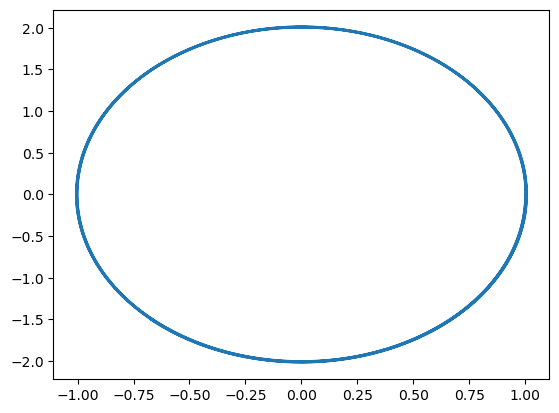

In [169]:
%reset -f
import numpy as np
import pylab as p

tmin = 0.0
tmax = 20.0
nts = 100000

x0 = 1
w = 2
phi = 0
beta = 0.1

def SHO_damp(x0, w, beta):
    t_array = np.linspace(tmin, tmax, nts, endpoint=False)  
    dt = t_array[1] - t_array[0]
    
    
    x_array = np.zeros(len(t_array))
    v_array = np.zeros(len(t_array))
    
    x_array[0] = x0
    v_array[0] = 0
    
    i = 0
    while i < nts - 1:
        v_array[i + 1] = v_array[i] + dt * (-pow(w, 2) * x_array[i] - beta * v_array[i])
        x_array[i + 1] = x_array[i] + dt * v_array[i]
        i += 1

    return x_array, v_array

x, v = SHO_damp(x0, w, beta)

p.plot(x, v)
p.show()

Again as one might expect, it dies down slowly. I will now show the comparison of the 3 types of integration; this code block will be dedicated to the first case, where there is a constant shift. The verlet integration is technically verlet velocity integration. I used the following link to help me write the code for the RK45, along with the materials given to us: https://stackoverflow.com/questions/56376061/solve-coupled-differential-equation-using-the-function-scipy-integrate-rk45. I also needed to resort to asking a comp sci friend how to properly iterate using this, and he gave me the solver.status solution that I'm using, which makes sense.

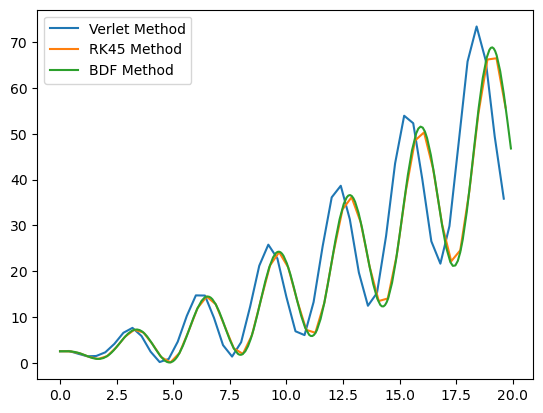

In [194]:
%reset -f
import numpy as np
import pylab as p
from scipy.integrate import RK45, BDF

tmin = 0.0
tmax = 20.0
nts = 50

x0 = 1
v0 = 1
w = 2
phi = 0
beta = 0.1

t_array = np.linspace(tmin, tmax, nts, endpoint=False)  
dt = t_array[1] - t_array[0]

def f(t, y):
    x, v = y
    a = -pow(w, 2) * x + t
    return [v, a]

def verlet(x0, v0, w):
    x_array = np.zeros(len(t_array))
    a_array = np.zeros(len(t_array))
    v_array = np.zeros(len(t_array))
    
    x_array[0] = x0
    a_array[0] = - pow(w, 2) * x_array[0]
    v_array[0] = v0
    
    i = 0
    while i < nts - 1:
        x_array[i + 1] = x_array[i] + dt * v_array[i] + pow(dt, 2) * 0.5 * a_array[i]
        a_array[i + 1] = - pow(w, 2) * x_array[i + 1]
        v_array[i + 1] = v_array[i] + dt * 0.5 * (a_array[i] + a_array[i + 1]) + dt * v0 * t_array[i]
        i += 1

    return x_array, v_array, a_array

#Verlet Velocity Solver with shift
x1, v1, a = verlet(x0, v0, w)

#Verlet Energy
E1 = np.zeros(len(x1))
i = 0
while i < len(x1):
    E1[i] = 0.5 * (pow(v1[i], 2) + pow(w * x1[i], 2))
    i += 1

#RK4(5) Solver with shift
solver2 = RK45(f, tmin, [x0, v0], tmax, dt)

t2 = []
x2 = []
v2 = []

while solver2.status == 'running':
    t2.append(solver2.t)
    x2.append(solver2.y[0])
    v2.append(solver2.y[1])
    solver2.step()

#RK4(5) Energy
E2 = np.zeros(len(x2))
i = 0
while i < len(x2):
    E2[i] = 0.5 * (pow(v2[i], 2) + pow(w * x2[i], 2))
    i += 1
    

#RDF Solver with shift
solver3 = BDF(f, tmin, [x0, v0], tmax, dt)

t3 = []
x3 = []
v3 = []

while solver3.status == 'running':
    t3.append(solver3.t)
    x3.append(solver3.y[0])
    v3.append(solver3.y[1])
    solver3.step()

#BDF Energy
E3 = np.zeros(len(x3))
i = 0
while i < len(x3):
    E3[i] = 0.5 * (pow(v3[i], 2) + pow(w * x3[i], 2))
    i += 1

p.plot(t_array, E1, label="Verlet Method")
p.plot(t2, E2, label="RK45 Method")
p.plot(t3, E3, label="BDF Method")
p.legend()
p.show()

The plots for the three integration methods in the case of a shifting Simple Harmonic Oscillator. Notice that the Verlet (the one I wrote) is a little bit worse for a low nts, and the other two are about even, with BDF being slightly better. The general shape of these plots is weird and I don't know if it's what I am supposed to see, but it is oscillating so I guess it kinda makes sense, and in general the energy is increasing over time, which I think is not supposed to happen. Strange, but don't know how to fix it. Now I will show the same three integrations in the case of the damped Simple Harmonic Oscillator.

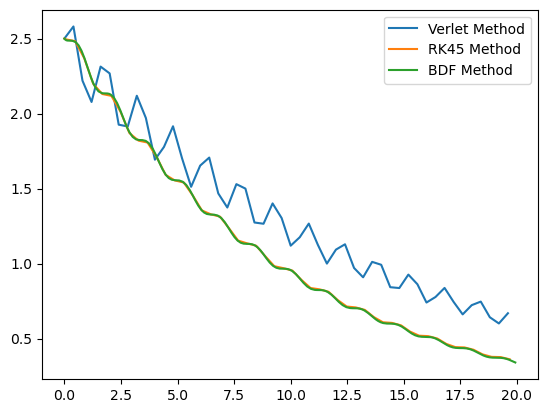

In [193]:
%reset -f
import numpy as np
import pylab as p
from scipy.integrate import RK45, BDF

tmin = 0.0
tmax = 20.0
nts = 50

x0 = 1
v0 = 1
w = 2
phi = 0
beta = 0.1

t_array = np.linspace(tmin, tmax, nts, endpoint=False)  
dt = t_array[1] - t_array[0]

def f(t, y):
    x, v = y
    a = -pow(w, 2) * x - beta * v
    return [v, a]

def verlet(x0, v0, w):
    x_array = np.zeros(len(t_array))
    a_array = np.zeros(len(t_array))
    v_array = np.zeros(len(t_array))
    
    x_array[0] = x0
    a_array[0] = - pow(w, 2) * x_array[0]
    v_array[0] = v0
    
    i = 0
    while i < nts - 1:
        x_array[i + 1] = x_array[i] + dt * v_array[i] + pow(dt, 2) * 0.5 * a_array[i]
        a_array[i + 1] = - pow(w, 2) * x_array[i + 1]
        v_array[i + 1] = v_array[i] + dt * 0.5 * (a_array[i] + a_array[i + 1]) - dt * beta * v_array[i]
        i += 1

    return x_array, v_array, a_array

#Verlet Velocity Solver; has shift built in
x1, v1, a = verlet(x0, v0, w)

#Verlet Energy
E1 = np.zeros(len(x1))
i = 0
while i < len(x1):
    E1[i] = 0.5 * (pow(v1[i], 2) + pow(w * x1[i], 2))
    i += 1

#RK4(5) Solver

solver2 = RK45(f, tmin, [x0, v0], tmax, dt)

t2 = []
x2 = []
v2 = []

while solver2.status == "running":
    t2.append(solver2.t)
    x2.append(solver2.y[0])
    v2.append(solver2.y[1])
    solver2.step()

#RK4(5) Energy
E2 = np.zeros(len(x2))
i = 0
while i < len(x2):
    E2[i] = 0.5 * (pow(v2[i], 2) + pow(w * x2[i], 2))
    i += 1
    

#RDF Solver
solver3 = BDF(f, tmin, [x0, v0], tmax, dt)

t3 = []
x3 = []
v3 = []

while solver3.status == "running":
    t3.append(solver3.t)
    x3.append(solver3.y[0])
    v3.append(solver3.y[1])
    solver3.step()

#BDF Energy
E3 = np.zeros(len(x3))
i = 0
while i < len(x3):
    E3[i] = 0.5 * (pow(v3[i], 2) + pow(w * x3[i], 2))
    i += 1

p.plot(t_array, E1, label="Verlet Method")
p.plot(t2, E2, label="RK45 Method")
p.plot(t3, E3, label="BDF Method")
p.legend()
p.show()

Here, the energy is generally decreasing over time, which is definitely supposed to be happening. Also again, the Verlet is worse than the other two methods, and with higher nts all the plots converge as one would expect (as they do for the shifting case). The also have an oscilliatory feel to them, which I can only hope is supposed to happen.